# Naive Bayes

## Setup

In [0]:
import mlflow
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import (
    VectorAssembler, MinMaxScaler, StandardScaler, StringIndexer, OneHotEncoder, Imputer, SQLTransformer
)

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, log1p, when

# Spark SQL API
from pyspark.sql import Window, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, concat, col, row_number, monotonically_increasing_id, udf, expr, abs, least, col, approx_count_distinct, stddev, mean, min, max

from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.ml.linalg import VectorUDT, SparseVector, Vectors, DenseVector
from pyspark.ml import Transformer

import pickle
import os
from functools import reduce
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt

# Hyperparameter optimization
import optuna
from optuna.pruners import MedianPruner

# Sklearn
from sklearn.model_selection import TimeSeriesSplit

#SMOTE
from imblearn.over_sampling import SMOTE

In [0]:
# set the experiment id
mlflow.set_experiment(experiment_id="59813923271508")
mlflow.autolog()


2024/12/11 03:12:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/11 03:12:31 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/12/11 03:12:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2024/12/11 03:12:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [0]:
# Mount blob storage and grant team access
blob_container  = "261project"       # The name of your container created in https://portal.azure.com
storage_account = "261teamderm"  # The name of your Storage account created in https://portal.azure.com
secret_scope = "261teamderm"           # The name of the scope created in your local computer using the Databricks CLI
secret_key = "261key"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket
mids261_mount_path      = "/mnt/mids-w261" # the 261 course blob storage is mounted here.
# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
  )

In [0]:
# Spark Context
sc = spark.sparkContext
spark

In [0]:
spark = SparkSession.builder.appName('ClassifyDelaysWithNB').getOrCreate()

# Functions

In [0]:
def cast_integers_to_double(df):
    """
    Cast all integer columns in a DataFrame to double.
    """
    integer_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() == "int"]
    for col_name in integer_cols:
        df = df.withColumn(col_name, col(col_name).cast("double"))
    return df

def check_min_values(df, numerical_cols):
    # Calculate min, median, and max for each numerical column
    agg_exprs = []
    for col_name in numerical_cols:
        agg_exprs.append(min(col(col_name)).cast("double").alias(f"{col_name}_min"))
        agg_exprs.append(expr(f"percentile_approx({col_name}, 0.5)").cast("double").alias(f"{col_name}_median"))
        agg_exprs.append(max(col(col_name)).cast("double").alias(f"{col_name}_max"))

    # Aggregate the values
    agg_df = df.agg(*agg_exprs)

    # Convert the aggregated DataFrame to a pivot table format
    pivot_df = agg_df.selectExpr("stack(" + f"{len(numerical_cols)}, " + ", ".join([f"'{col_name}', {col_name}_min, {col_name}_median, {col_name}_max" for col_name in numerical_cols]) + ") as (column, min, median, max)")

    # Display the pivot table
    display(pivot_df)


def shift_to_positive(df, numerical_cols, manual=False, manual_value=None):
    # Calculate the absolute minimum value across all numerical columns
    absolute_min_value = df.select(
         least(*[col(c) for c in numerical_cols]).alias("absolute_min")
     ).agg({"absolute_min": "min"}).collect()[0][0]
 
    # If the minimum value is negative, shift all numerical    
    if manual:
        shifted_value = manual_value
        for col_name in numerical_cols:
            df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
            display(f"Abs min value < 0, shifting {col_name} by {shifted_value}")
    else:
        shift = 100
        if absolute_min_value < 0:
            shifted_value = (absolute_min_value * -1) + shift
            for col_name in numerical_cols:
                df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
                display(f"Abs min value < 0, shifting {col_name} by {shifted_value}")
        else:
            shifted_value = absolute_min_value + shift
            for col_name in numerical_cols:
                df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
                display(f"Abs min value >= 0, shifting {col_name} by {shifted_value}")
    return df

def get_train_val_data(df, fold):
    """
    Function to filter training and validation sets
    """
    train_data = df.filter((col('split') == 'train') & (col('foldCol') == fold))
    val_data = df.filter((col('split') == 'val') & (col('foldCol') == fold))
    return train_data, val_data

def get_sampled_dataset(df, drop_constants=False):
    
    # Filter for a test dataframe using one fold and a percentage of the data stratified by the 'split' column
    fold = 0
    perc = 0.01

    # Sample and create test_df
    test_df = df.filter(col('foldCol') == fold).sampleBy('split', fractions={'train': perc, 'val': perc})

    # Total row count for relative thresholding
    total_rows = test_df.count()

    # Redefine constant_cols with relative threshold
    constant_cols = [
        c for c in numerical_cols 
        if test_df.agg(approx_count_distinct(col(c)).alias("distinct")).collect()[0]["distinct"] / total_rows < 0.10
    ]
    non_constant_numerical_cols = [
        c for c in numerical_cols 
        if test_df.agg(approx_count_distinct(col(c)).alias("distinct")).collect()[0]["distinct"] / total_rows >= 0.10
    ]

    # Filter columns for numerical and categorical cols
    test_df = test_df.select(constant_cols + non_constant_numerical_cols + categorical_cols + ['split', 'foldCol', label_col])

    if drop_constants:
        test_df = test_df.drop(*constant_cols)

    return test_df, constant_cols, non_constant_numerical_cols


# Additional pre-processing

## Read data from Blob

In [0]:
# Get data
filtered_df = spark.read.parquet(f"{team_blob_url}/data/5yr_preprocessed.parquet")

## Set columns

In [0]:
# Define feature columns
ignore_cols = ['ORIGIN', 'DEST','FL_DATE', 'CANCELLED', 'YEAR']

# Enumerate columns for ohe ("categorical"), already ohe ("ohe") and for scaling ()
need_ohe_cols = ['QUARTER', 'MONTH', 'DAY_OF_WEEK','OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'DAY_OF_MONTH', 'HIST_ARR_FLT_NUM', 'HIST_DEP_FLT_NUM']
already_ohe_cols = ['ceiling_height_is_below_10000', 'ceiling_height_is_between_10000_20000', 'ceiling_height_is_above_20000', 'isHoliday', 'specWeather']
standard_scalar_cols = ['wind_direction', 'temperature', 'sea_level_pressure'] # wind, temp and pressure
min_max_cols = ['CRS_ELAPSED_TIME', 'DISTANCE', # Time and distance
                'dew_point', 'wind_speed',  # vis, dew, weather and wind
                'origin_yr_flights', 'dest_yr_flights', # origin/dest
                'HIST_ARR_DELAY', 'HIST_DEP_DELAY' # lag columns for previous flights
                ]
unscaled_cols =['visibility', 'gust_speed','pagerank']

# Consolidate
categorical_cols = need_ohe_cols + already_ohe_cols
numerical_cols = standard_scalar_cols + min_max_cols + unscaled_cols
label_col = 'DEP_DEL15'


## Shift column values below 0 to above 0

In [0]:
# Shift values if negative values exist
shifted_df = shift_to_positive(filtered_df, numerical_cols)

# Cast integers as doubles
shifted_df = cast_integers_to_double(shifted_df)

'Abs min value < 0, shifting wind_direction by 304.0'

'Abs min value < 0, shifting temperature by 304.0'

'Abs min value < 0, shifting sea_level_pressure by 304.0'

'Abs min value < 0, shifting CRS_ELAPSED_TIME by 304.0'

'Abs min value < 0, shifting DISTANCE by 304.0'

'Abs min value < 0, shifting dew_point by 304.0'

'Abs min value < 0, shifting wind_speed by 304.0'

'Abs min value < 0, shifting origin_yr_flights by 304.0'

'Abs min value < 0, shifting dest_yr_flights by 304.0'

'Abs min value < 0, shifting HIST_ARR_DELAY by 304.0'

'Abs min value < 0, shifting HIST_DEP_DELAY by 304.0'

'Abs min value < 0, shifting visibility by 304.0'

'Abs min value < 0, shifting gust_speed by 304.0'

'Abs min value < 0, shifting pagerank by 304.0'

## Check results of shift

In [0]:
# Check results of shifting - Original pre-shifting
check_min_values(filtered_df, numerical_cols)

column min median max wind_direction 4.0 200.0 360.0 temperature -36.0 17.8 999.9 sea_level_pressure 976.4 1016.5 1059.6 CRS_ELAPSED_TIME -99.0 125.0 600.0 DISTANCE 25.0 667.0 2724.0 dew_point -38.5 11.1 999.9 wind_speed 0.0 3.6 999.9 origin_yr_flights 0.25 116259.75 373483.0 dest_yr_flights 0.5 116259.75 373483.0 HIST_ARR_DELAY -165.0 -5.0 1944.0 HIST_DEP_DELAY -204.0 -1.0 2755.0 visibility 0.0 16.093 999.999 gust_speed 1.0 5.0 9.0 pagerank 0.17876605400316553 4.440500308291283 18.870652648762693

In [0]:

# Check results of shifting - Post-shifting
check_min_values(shifted_df, numerical_cols)

column min median max wind_direction 308.0 504.0 664.0 temperature 268.0 321.8 1303.9 sea_level_pressure 1280.4 1320.5 1363.6 CRS_ELAPSED_TIME 205.0 429.0 904.0 DISTANCE 329.0 971.0 3028.0 dew_point 265.5 315.1 1303.9 wind_speed 304.0 307.6 1303.9 origin_yr_flights 304.25 116563.75 373787.0 dest_yr_flights 304.5 116563.75 373787.0 HIST_ARR_DELAY 139.0 299.0 2248.0 HIST_DEP_DELAY 100.0 303.0 3059.0 visibility 304.0 320.093 1303.999 gust_speed 305.0 309.0 313.0 pagerank 304.1787660540032 308.4405003082913 322.8706526487627

In [0]:
# Get shape of dataframe
shifted_df.count()

9037529

In [0]:
shifted_df = shifted_df[col("pagerank").isNotNull()]

In [0]:
display(shifted_df.groupBy("foldCol", "split",label_col).count().orderBy("foldCol", "split", label_col))

foldCol split DEP_DEL15 count 0.0 train 0.0 320637 0.0 train 1.0 293693 0.0 val 0.0 79405 0.0 val 1.0 76895 1.0 train 0.0 343989 1.0 train 1.0 358153 1.0 val 0.0 100212 1.0 val 1.0 102470 2.0 train 0.0 465489 2.0 train 1.0 416468 2.0 val 0.0 112681 2.0 val 1.0 123392 3.0 train 0.0 460277 3.0 train 1.0 449079 3.0 val 0.0 115443 3.0 val 1.0 110879 4.0 train 0.0 453133 4.0 train 1.0 466884 4.0 val 0.0 113717 4.0 val 1.0 118267 5.0 train 0.0 458850 5.0 train 1.0 454684 5.0 val 0.0 114195 5.0 val 1.0 108077 6.0 train 0.0 453365 6.0 train 1.0 463196 6.0 val 0.0 111402 6.0 val 1.0 122314 7.0 train 0.0 453972 7.0 train 1.0 464073 7.0 val 0.0 116821 7.0 val 1.0 106249

# Filter for test set and run Optuna

In [0]:
# Get sampled dataset
test_df, constant_cols, non_constant_numerical_cols = get_sampled_dataset(shifted_df, drop_constants=False)

# See results
display(test_df.groupBy("foldCol", "split",label_col).count().orderBy("foldCol", "split", label_col))
display(test_df)
print('constant_cols:', constant_cols)
print('non_constant_numerical_cols:', non_constant_numerical_cols)


foldCol split DEP_DEL15 count 0.0 train 0.0 3194 0.0 train 1.0 2909 0.0 val 0.0 774 0.0 val 1.0 745

wind_direction temperature sea_level_pressure CRS_ELAPSED_TIME dew_point wind_speed origin_yr_flights dest_yr_flights HIST_ARR_DELAY HIST_DEP_DELAY visibility gust_speed pagerank DISTANCE QUARTER MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER DEP_TIME_BLK ARR_TIME_BLK DAY_OF_MONTH HIST_ARR_FLT_NUM HIST_DEP_FLT_NUM ceiling_height_is_below_10000 ceiling_height_is_between_10000_20000 ceiling_height_is_above_20000 isHoliday specWeather split foldCol DEP_DEL15 384.0 315.1 null 380.0 314.6 306.1 98537.0 118742.25 null null 304.201 309.0 307.90958250964826 473.0 4.0 12.0 3.0 EV 1900-1959 2000-2059 2.0 3.0 3.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 584.0 314.0 1314.4 384.0 304.0 307.1 284195.5 131059.5 303.0 297.0 320.093 309.0 318.87296424220943 539.0 2.0 4.0 5.0 EV 0800-0859 1000-1059 3.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 null null null 421.0 null null 131059.5 100525.0 295.0 300.0 null null 310.1467909540767 813.0 2.0 6.0 5.0 DL 1300-1359 1500-1559 5.0 2.0 1.0 0.0 0.0 0.0 0.0 0.0 train 0.0 1.0 364.0 328.4 null 460.0 324.0 310.7 123678.75 131059.5 294.0 302.0 320.093 309.0 309.1761766871322 1261.0 2.0 4.0 7.0 DL 1500-1559 1800-1859 5.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 494.0 323.0 null 353.0 322.0 306.6 1174.0 226189.25 307.0 309.0 306.816 309.0 304.23832895003585 417.0 2.0 5.0 2.0 EV 0001-0559 0600-0659 5.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 354.0 324.0 1327.9 490.0 319.6 305.5 100525.0 83756.75 300.0 304.0 320.093 309.0 308.1966896660273 1373.0 3.0 9.0 7.0 B6 1300-1359 1600-1659 6.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 train 0.0 1.0 374.0 320.7 1322.7 357.0 315.1 308.1 31960.75 284195.5 304.0 296.0 320.093 309.0 305.4715506569633 371.0 3.0 7.0 3.0 OO 2000-2059 2100-2159 8.0 2.0 2.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 null 332.0 null 404.0 322.0 306.1 86772.5 43747.5 264.0 301.0 316.875 309.0 307.59721228026234 881.0 3.0 8.0 7.0 WN 2100-2159 2300-2359 9.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 334.0 331.8 1313.2 441.0 312.9 308.1 221924.5 11284.25 331.0 321.0 320.093 309.0 314.3750362381464 1140.0 3.0 7.0 5.0 UA 2200-2259 2300-2359 10.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 524.0 335.1 1315.5 464.0 325.7 307.1 148111.25 158307.5 320.0 324.0 320.093 309.0 311.36825725966816 1313.0 2.0 6.0 4.0 UA 1700-1759 1800-1859 11.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 574.0 335.1 1317.5 446.0 325.7 310.2 21916.75 100525.0 364.0 371.0 320.093 309.0 304.9438335836865 1132.0 3.0 9.0 5.0 B6 1800-1859 2000-2059 11.0 2.0 2.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 434.0 324.0 1319.9 385.0 320.7 305.5 226189.25 7271.0 298.0 304.0 320.093 309.0 317.9682178970524 613.0 2.0 6.0 2.0 MQ 0900-0959 1000-1059 2.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 null 317.9 1316.0 394.0 316.8 304.0 164812.0 151393.0 286.0 341.0 320.093 309.0 310.7204875021905 718.0 4.0 11.0 1.0 WN 1300-1359 1400-1459 2.0 2.0 1.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 null 322.0 null 584.0 321.0 304.0 1456.0 151393.0 298.0 418.0 320.093 309.0 304.24709225221795 2258.0 3.0 7.0 5.0 NK 0700-0759 0800-0859 3.0 2.0 1.0 0.0 0.0 1.0 1.0 0.0 train 0.0 1.0 null null null 419.0 null null 131059.5 139765.75 301.0 300.0 null null 310.1991850735685 804.0 3.0 9.0 4.0 DL 2000-2059 2200-2259 3.0 2.0 1.0 0.0 0.0 0.0 0.0 0.0 train 0.0 1.0 424.0 327.0 null 499.0 326.0 305.5 43747.5 148111.25 311.0 310.0 312.047 309.0 305.5823039257504 1494.0 3.0 7.0 1.0 UA 1200-1259 1400-1459 6.0 2.0 2.0 1.0 0.0 0.0 1.0 1.0 train 0.0 1.0 514.0 325.1 1312.0 386.0 322.3 312.2 284195.5 29791.75 324.0 322.0 320.093 309.0 318.87296424220943 600.0 2.0 6.0 7.0 MQ 1700-1759 2000-2059 7.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 494.0 327.3 1326.4 487.0 311.2 309.1 116563.75 24716.75 300.0 552.0 320.093 309.0 308.78680320913065 1339.0 2.0 5.0 4.0 DL 1800-1859 2100-2159 7.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 494.0 325.0 null 360.0 323.0 311.2 373787.0 5269.5 376.0 446.0 310.437 309.0 321.6883850872604 455.0 2.0 6.0 2.0 DL 2300-2359 2300-2359 9.0 2.0 1.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 564.0 337.9 1308.3 504.0 300.7 309.1 15

constant_cols: ['wind_direction', 'temperature', 'sea_level_pressure', 'CRS_ELAPSED_TIME', 'dew_point', 'wind_speed', 'origin_yr_flights', 'dest_yr_flights', 'HIST_ARR_DELAY', 'HIST_DEP_DELAY', 'visibility', 'gust_speed', 'pagerank']
non_constant_numerical_cols: ['DISTANCE']


In [0]:
from pyspark.sql.functions import col

# ======================================== Set for Testing =============================================
# Update as needed
test=False

# ===================================== Set data and n trials ==========================================

# Set df and n_trials
if test:
    df = test_df
    n_trials = 1
else:
    df = shifted_df
    n_trials = 5

# ============================= Define Objective Function + Metrics ===================================

def objective(trial):
    # Hyperparameter search
    smoothing = trial.suggest_float("smoothing", 0.01, 10.0, log=True)
    imputation_strategy = trial.suggest_categorical("imputation_strategy", ["mean", "median"])

    # Apply imputer for all numerical columns
    imputer = Imputer(
        strategy=imputation_strategy,
        inputCols=numerical_cols,
        outputCols=[f"{col}_imputed" for col in numerical_cols]
    )

    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
        for col in categorical_cols
    ]
    encoders = [
        OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
        for col in categorical_cols
    ]

    assembler = VectorAssembler(
        inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
        outputCol="features"
    )

    model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

    pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model]) 

    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")

    fold_metrics = {"train": [], "val": []}
    num_folds = df.select('foldCol').distinct().count()
    fold_weights = range(1, num_folds + 1)

    for fold in range(num_folds):
        train_data, val_data = get_train_val_data(df, fold)

        pipeline_model = pipeline.fit(train_data)

        # Evaluate on train and validation data
        for split_name, data in [("train", train_data), ("val", val_data)]:
            predictions = pipeline_model.transform(data)
            auc = evaluator.evaluate(predictions)

            # Compute metrics
            tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
            fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
            fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
            tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

            f1_micro = accuracy
            f1_macro = (precision + recall) / 2 if (precision + recall) > 0 else 0
            f1_weighted = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            beta = 0.5
            fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

            # Store fold metrics
            fold_metrics[split_name].append({
                "fold": fold,
                "auc": auc,
                "precision": precision,
                "recall": recall,
                "accuracy": accuracy,
                "f1_micro": f1_micro,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "fbeta": fbeta,
                "weight": fold_weights[fold]
            })

            # Log fold-specific metrics
            for metric_name, metric_value in {
                "auc": auc, "precision": precision, "recall": recall,
                "accuracy": accuracy, "f1_micro": f1_micro, "f1_macro": f1_macro,
                "f1_weighted": f1_weighted, "fbeta": fbeta
            }.items():
                trial.set_user_attr(f"{split_name}_fold_{fold}_{metric_name}", metric_value)

    # Aggregate metrics across folds for train and val separately
    metrics_per_split = {}
    for split_name in ["train", "val"]:
        total_weight = sum(m["weight"] for m in fold_metrics[split_name])

        metrics_per_split[split_name] = {
            metric: sum(m[metric] * m["weight"] for m in fold_metrics[split_name]) / total_weight
            for metric in ["auc", "precision", "recall", "accuracy", "f1_micro", "f1_macro", "f1_weighted", "fbeta"]
        }

    # Log aggregated metrics
    for split_name, metrics in metrics_per_split.items():
        for metric_name, metric_value in metrics.items():
            trial.set_user_attr(f"{split_name}_weighted_average_{metric_name}", metric_value)

    # Store per-fold metrics for later analysis
    trial.set_user_attr("fold_metrics", fold_metrics)

    trial.report(metrics_per_split["val"]["fbeta"], step=0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    print('Fold metrics stored in trial user attributes')
    print('val fbeta:', metrics_per_split["val"]["fbeta"])
    return metrics_per_split["val"]["fbeta"]

# ======================================== Run Optuna Study ============================================

# Create Optuna study with MedianPruner
study = optuna.create_study(direction="maximize", 
                            pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1
                                                )
                            )
study.optimize(objective, 
               n_trials=n_trials, 
               n_jobs=-1
               )


[I 2024-12-11 03:20:48,972] A new study created in memory with name: no-name-1f40d2f3-bf1f-4570-adf0-c2552a7a2841
2024/12/11 03:22:21 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


2024/12/11 03:23:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/59813923271508/8fc00c842d464a4f92b3ad901f3e931d/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.2']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2024/12/11 03:23:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-shark-100 at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508/runs/8fc00c842d464a4f92b3ad901f3e931d.
2024/12/11 03:23:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508.
2024/12/11 03:23:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4b35024ef80f47e6a97f8be74c713eef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/12/11 03:23:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1c77f73528dd4da9a4d946b8b4447dad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/12/11 03:23:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 

Fold metrics stored in trial user attributes
val fbeta: 0.5152546632465778
Fold metrics stored in trial user attributes
val fbeta: 0.5152546632465778


[I 2024-12-11 03:30:16,331] Trial 0 finished with value: 0.51525001391661 and parameters: {'smoothing': 0.015475907317116675, 'imputation_strategy': 'median'}. Best is trial 4 with value: 0.5152546632465778.


Fold metrics stored in trial user attributes
val fbeta: 0.51525001391661


[I 2024-12-11 03:30:19,558] Trial 1 finished with value: 0.51525001391661 and parameters: {'smoothing': 0.012833526292887133, 'imputation_strategy': 'median'}. Best is trial 4 with value: 0.5152546632465778.


Fold metrics stored in trial user attributes
val fbeta: 0.51525001391661


2024/12/11 03:30:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-whale-872 at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508/runs/9f33c93ead814e31b128277c086c0327.
2024/12/11 03:30:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508.
[I 2024-12-11 03:30:37,238] Trial 2 finished with value: 0.51525001391661 and parameters: {'smoothing': 0.02000380854826903, 'imputation_strategy': 'median'}. Best is trial 4 with value: 0.5152546632465778.


Fold metrics stored in trial user attributes
val fbeta: 0.51525001391661


In [0]:
import pandas as pd

try:
    display(df_metrics.loc[0, 'user_attrs_failure_reason'])
except:
    pass

In [0]:
def study_to_dataframe(study):
    records = []
    for trial in study.trials:
        # Extract general metrics
        record = {
            "trial_number": trial.number,
            "state": trial.state.name,  # Use human-readable state
            "train_accuracy": trial.user_attrs.get("train_weighted_average_accuracy"),
            "train_auc": trial.user_attrs.get("train_weighted_average_auc"),
            "train_f1_macro": trial.user_attrs.get("train_weighted_average_f1_macro"),
            "train_f1_micro": trial.user_attrs.get("train_weighted_average_f1_micro"),
            "train_f1_weighted": trial.user_attrs.get("train_weighted_average_f1_weighted"),
            "train_fbeta": trial.user_attrs.get("train_weighted_average_fbeta"),
            "train_precision": trial.user_attrs.get("train_weighted_average_precision"),
            "train_recall": trial.user_attrs.get("train_weighted_average_recall"),
            "val_accuracy": trial.user_attrs.get("val_weighted_average_accuracy"),
            "val_auc": trial.user_attrs.get("val_weighted_average_auc"),
            "val_f1_macro": trial.user_attrs.get("val_weighted_average_f1_macro"),
            "val_f1_micro": trial.user_attrs.get("val_weighted_average_f1_micro"),
            "val_f1_weighted": trial.user_attrs.get("val_weighted_average_f1_weighted"),
            "val_fbeta": trial.user_attrs.get("val_weighted_average_fbeta"),
            "val_precision": trial.user_attrs.get("val_weighted_average_precision"),
            "val_recall": trial.user_attrs.get("val_weighted_average_recall"),
            **trial.params,  # Add hyperparameters as columns
        }

        # Add fold-specific metrics
        for key, value in trial.user_attrs.items():
            if "fold_" in key:  # Capture fold-specific metrics
                record[key] = value

        records.append(record)

    # Create a DataFrame with pyspark.pandas
    df_metrics = ps.DataFrame(records)
    return df_metrics


# Convert study results to a DataFrame
df_metrics = study_to_dataframe(study)

In [0]:
display(df_metrics)

trial_number state train_accuracy train_auc train_f1_macro train_f1_micro train_f1_weighted train_fbeta train_precision train_recall val_accuracy val_auc val_f1_macro val_f1_micro val_f1_weighted val_fbeta val_precision val_recall smoothing imputation_strategy train_fold_0_auc train_fold_0_precision train_fold_0_recall train_fold_0_accuracy train_fold_0_f1_micro train_fold_0_f1_macro train_fold_0_f1_weighted train_fold_0_fbeta val_fold_0_auc val_fold_0_precision val_fold_0_recall val_fold_0_accuracy val_fold_0_f1_micro val_fold_0_f1_macro val_fold_0_f1_weighted val_fold_0_fbeta train_fold_1_auc train_fold_1_precision train_fold_1_recall train_fold_1_accuracy train_fold_1_f1_micro train_fold_1_f1_macro train_fold_1_f1_weighted train_fold_1_fbeta val_fold_1_auc val_fold_1_precision val_fold_1_recall val_fold_1_accuracy val_fold_1_f1_micro val_fold_1_f1_macro val_fold_1_f1_weighted val_fold_1_fbeta train_fold_2_auc train_fold_2_precision train_fold_2_recall train_fold_2_accuracy train_fold_2_f1_micro train_fold_2_f1_macro train_fold_2_f1_weighted train_fold_2_fbeta val_fold_2_auc val_fold_2_precision val_fold_2_recall val_fold_2_accuracy val_fold_2_f1_micro val_fold_2_f1_macro val_fold_2_f1_weighted val_fold_2_fbeta train_fold_3_auc train_fold_3_precision train_fold_3_recall train_fold_3_accuracy train_fold_3_f1_micro train_fold_3_f1_macro train_fold_3_f1_weighted train_fold_3_fbeta val_fold_3_auc val_fold_3_precision val_fold_3_recall val_fold_3_accuracy val_fold_3_f1_micro val_fold_3_f1_macro val_fold_3_f1_weighted val_fold_3_fbeta train_fold_4_auc train_fold_4_precision train_fold_4_recall train_fold_4_accuracy train_fold_4_f1_micro train_fold_4_f1_macro train_fold_4_f1_weighted train_fold_4_fbeta val_fold_4_auc val_fold_4_precision val_fold_4_recall val_fold_4_accuracy val_fold_4_f1_micro val_fold_4_f1_macro val_fold_4_f1_weighted val_fold_4_fbeta train_fold_5_auc train_fold_5_precision train_fold_5_recall train_fold_5_accuracy train_fold_5_f1_micro train_fold_5_f1_macro train_fold_5_f1_weighted train_fold_5_fbeta val_fold_5_auc val_fold_5_precision val_fold_5_recall val_fold_5_accuracy val_fold_5_f1_micro val_fold_5_f1_macro val_fold_5_f1_weighted val_fold_5_fbeta train_fold_6_auc train_fold_6_precision train_fold_6_recall train_fold_6_accuracy train_fold_6_f1_micro train_fold_6_f1_macro train_fold_6_f1_weighted train_fold_6_fbeta val_fold_6_auc val_fold_6_precision val_fold_6_recall val_fold_6_accuracy val_fold_6_f1_micro val_fold_6_f1_macro val_fold_6_f1_weighted val_fold_6_fbeta train_fold_7_auc train_fold_7_precision train_fold_7_recall train_fold_7_accuracy train_fold_7_f1_micro train_fold_7_f1_macro train_fold_7_f1_weighted train_fold_7_fbeta val_fold_7_auc val_fold_7_precision val_fold_7_recall val_fold_7_accuracy val_fold_7_f1_micro val_fold_7_f1_macro val_fold_7_f1_weighted val_fold_7_fbeta fold_metrics 0 COMPLETE 0.5162610061245546 0.5000656212370447 0.5196206205605912 0.5162610061245546 0.5195450539308681 0.5173360213438075 0.5158922705785284 0.523348970542654 0.5146993385226755 0.5041959530218325 0.5178677517478454 0.5146993385226755 0.5176378643841688 0.51525001391661 0.5137468355755248 0.5219886679201661 0.015475907317116675 median 0.4925285777624291 0.4982165580534454 0.5279083941394586 0.5201227353376849 0.5201227353376849 0.513062476096452 0.5126328962834504 0.5038846859589061 0.5056694771105463 0.5115599255912836 0.5257168866636323 0.5197184900831734 0.5197184900831734 0.5186384061274579 0.518541797611565 0.5143299905594841 0.4937186076234962 0.5299190633349049 0.527218814305618 0.5202807979012792 0.5202807979012792 0.5285689388202615 0.5285654901949807 0.5293768030210853 0.49223055476055255 0.5259038026079488 0.5258319508148727 0.5206185058367294 0.5206185058367294 0.5258678767114107 0.525867874257049 0.5258894306784776 0.48776197021407564 0.4895731519616765 0.523175850245397 0.5172678486592884 0.5172678486592884 0.5063745011035368 0.5058170375417431 0.4959438789445892 0.4947000468173685 0.5405348811886993

In [0]:
# Explicitly convert each column to string
df_metrics_str = df_metrics.select([df_metrics[col].cast("string").alias(col) for col in df_metrics.columns])

# Display the DataFrame
display(df_metrics.transpose())


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/spark/python/pyspark/pandas/frame.py:13569, in DataFrame.__getattr__(self, key)
  13568 try:
> 13569     return self.loc[:, key]
  13570 except KeyError:

File /databricks/spark/python/pyspark/pandas/indexing.py:485, in LocIndexerLike.__getitem__(self, key)
    478 cond, limit, remaining_index = self._select_rows(rows_sel)
    479 (
    480     column_labels,
    481     data_spark_columns,
    482     data_fields,
    483     returns_series,
    484     series_name,
--> 485 ) = self._select_cols(cols_sel)
    487 if cond is None and limit is None and returns_series:

File /databricks/spark/python/pyspark/pandas/indexing.py:332, in LocIndexerLike._select_cols(self, cols_sel, missing_keys)
    331 else:
--> 332     return self._select_cols_else(cols_sel, missing_keys)

File /databricks/spark/python/pyspark/pandas/indexin

In [0]:
# Optionally save to CSV
# df_metrics.to_csv(f"{team_blob_url}/results/4yr_nb_optuna_results.csv", index=True)

# Run and save Optuna study

In [0]:

study_name = "nb_study_1yr_2024_12_08"

# Save the study object locally as a pickle file
local_pickle_path = f"/tmp/{study_name}.pkl"

with open(local_pickle_path, "wb") as f:
    pickle.dump(study, f)

print(f"Study saved locally to {local_pickle_path}")

# Use Spark to upload the pickle file to Azure Blob Storage
dbutils.fs.cp(f"file://{local_pickle_path}", f"{team_blob_url}/data/{study_name}.pkl")
print(f"Study uploaded to {team_blob_url}/data/{study_name}.pkl")

Study saved locally to /tmp/nb_study_1yr_2024_12_08.pkl
Study uploaded to wasbs://261project@261teamderm.blob.core.windows.net/data/nb_study_1yr_2024_12_08.pkl


# See log probabilities

2024/12/10 05:09:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '178acfc57a344c248935b759a7690a9b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/12/10 05:10:35 WARNING mlflow.pyspark.ml: Model outputs contain unsupported Spark data types: [StructField('QUARTER_ohe', VectorUDT(), True), StructField('MONTH_ohe', VectorUDT(), True), StructField('DAY_OF_WEEK_ohe', VectorUDT(), True), StructField('OP_UNIQUE_CARRIER_ohe', VectorUDT(), True), StructField('DEP_TIME_BLK_ohe', VectorUDT(), True), StructField('ARR_TIME_BLK_ohe', VectorUDT(), True), StructField('DAY_OF_MONTH_ohe', VectorUDT(), True), StructField('HIST_ARR_FLT_NUM_ohe', VectorUDT(), True), StructField('HIST_DEP_FLT_NUM_ohe', VectorUDT(), True), StructField('features', VectorUDT(), True), StructField('rawPrediction', VectorUDT(), True), StructField('probability', VectorUDT(), True)]. Output schema is not be log

2024/12/10 05:13:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/59813923271508/178acfc57a344c248935b759a7690a9b/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.2']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2024/12/10 05:13:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-shrimp-647 at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508/runs/178acfc57a344c248935b759a7690a9b.
2024/12/10 05:13:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508.


Class Priors: [-0.6867505674655057,-0.6995849738686797]
Feature Log Probabilities (theta):
[[-13.75578916 -13.76625356 -13.7589529  -14.0969906  -14.86509157
  -14.88330445 -14.85463133 -14.8554093  -14.91584629 -14.85613573
  -14.80639773 -14.85345739 -14.84359691 -15.12967013 -15.22982686
  -15.23072222 -14.36568516 -14.35627697 -14.36704101 -14.3534167
  -14.40653351 -14.37274608 -14.55126104 -13.9785248  -14.34547894
  -14.2555936  -14.58684617 -14.81696754 -15.14826713 -15.62273053
  -16.17442367 -16.27024179 -16.1266059  -16.54681255 -16.74901402
  -16.94641862 -17.16047842 -17.03184759 -17.15218853 -17.79010327
  -18.09773229 -15.24597095 -15.42456513 -15.28167757 -15.45535386
  -15.37266074 -15.22795821 -15.28451933 -15.36268202 -15.20576551
  -15.19714458 -15.61661888 -15.06851923 -15.01624094 -14.94932543
  -15.19974191 -16.05782667 -16.21826119 -15.96216287 -17.47613256
  -15.32723029 -15.33799877 -15.29291178 -15.38577932 -15.17974415
  -15.29835849 -15.23590161 -15.6001150

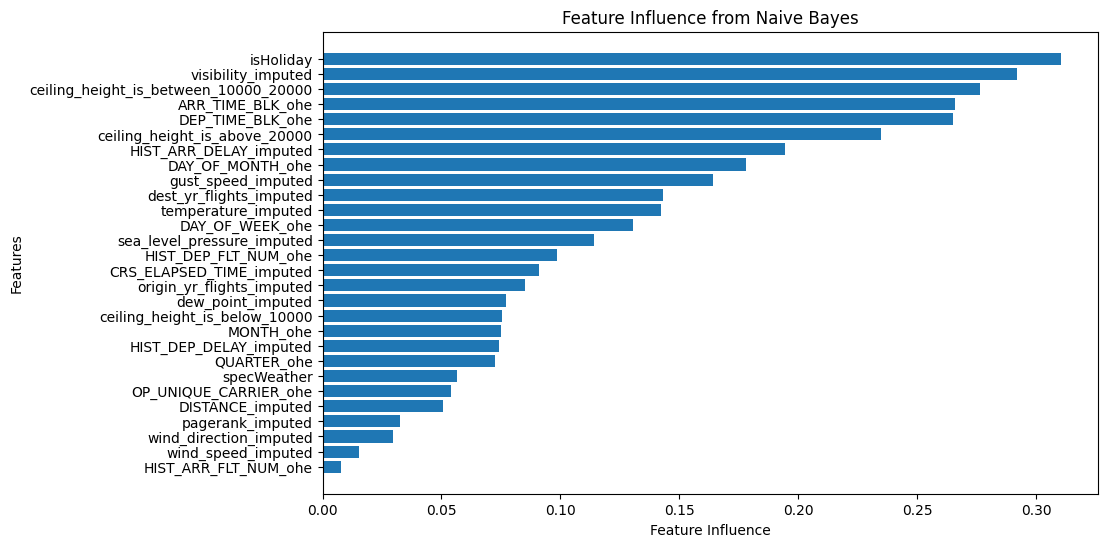

In [0]:
# Extract best hyperparameters
best_params = study.best_params
smoothing = best_params["smoothing"]
imputation_strategy = best_params["imputation_strategy"]

# Update the pipeline with best hyperparameters
imputer = Imputer(
    strategy=imputation_strategy,
    inputCols=numerical_cols,
    outputCols=[f"{col}_imputed" for col in numerical_cols]
)

# Handle categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index", handleInvalid="keep") for column in need_ohe_cols]
encoders = [OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe") for column in need_ohe_cols]

assembler = VectorAssembler(
    inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
    outputCol="features"
)

model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model])

# Fit the model
pipeline_model = pipeline.fit(shifted_df.filter(col('split')=='train'))
nb_model = pipeline_model.stages[-1]  

# Extract feature log probabilities
feature_log_probs = np.array(nb_model.theta.toArray())

# Extract class priors and feature log probabilities
class_priors = nb_model.pi
feature_log_probs = nb_model.theta.toArray()

print("Class Priors:", class_priors)
print("Feature Log Probabilities (theta):")
print(feature_log_probs)

# Calculate feature influence (e.g., difference between classes)
feature_influence = np.abs(feature_log_probs[0] - feature_log_probs[1])

# Map to feature names
feature_names = assembler.getInputCols()
feature_influence_dict = dict(zip(feature_names, feature_influence))

# Sort features by influence
sorted_features = sorted(feature_influence_dict.items(), key=lambda x: x[1], reverse=True)
sorted_names, sorted_values = zip(*sorted_features)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_values)
plt.xlabel("Feature Influence")
plt.ylabel("Features")
plt.title("Feature Influence from Naive Bayes")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [0]:
# Extract best hyperparameters
best_params = study.best_params
smoothing = best_params["smoothing"]
imputation_strategy = best_params["imputation_strategy"]

# Update the pipeline with best hyperparameters
imputer = Imputer(
    strategy=imputation_strategy,
    inputCols=numerical_cols,
    outputCols=[f"{col}_imputed" for col in numerical_cols]
)

# Handle categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index", handleInvalid="keep") for column in need_ohe_cols]
encoders = [OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe") for column in need_ohe_cols]

assembler = VectorAssembler(
    inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
    outputCol="features"
)

model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model])

# Fit the model
pipeline_model = pipeline.fit(shifted_df.filter(col('split') == 'train'))
nb_model = pipeline_model.stages[-1]  

# Extract feature log probabilities
feature_log_probs = np.array(nb_model.theta.toArray())

# Calculate feature influence
feature_differences = feature_log_probs[0] - feature_log_probs[1]

class_0_influence = {feature_names[i]: feature_differences[i] if feature_differences[i] > 0 else 0 for i in range(len(feature_names))}
class_1_influence = {feature_names[i]: -feature_differences[i] if feature_differences[i] < 0 else 0 for i in range(len(feature_names))}

# Sort influences
sorted_class_0 = sorted(class_0_influence.items(), key=lambda x: x[1], reverse=True)
sorted_class_1 = sorted(class_1_influence.items(), key=lambda x: x[1], reverse=True)

# Unpack sorted values
sorted_names_0, sorted_values_0 = zip(*sorted_class_0)
sorted_names_1, sorted_values_1 = zip(*sorted_class_1)

2024/12/10 05:24:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e10ed05f526142958465bd397206b3ac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

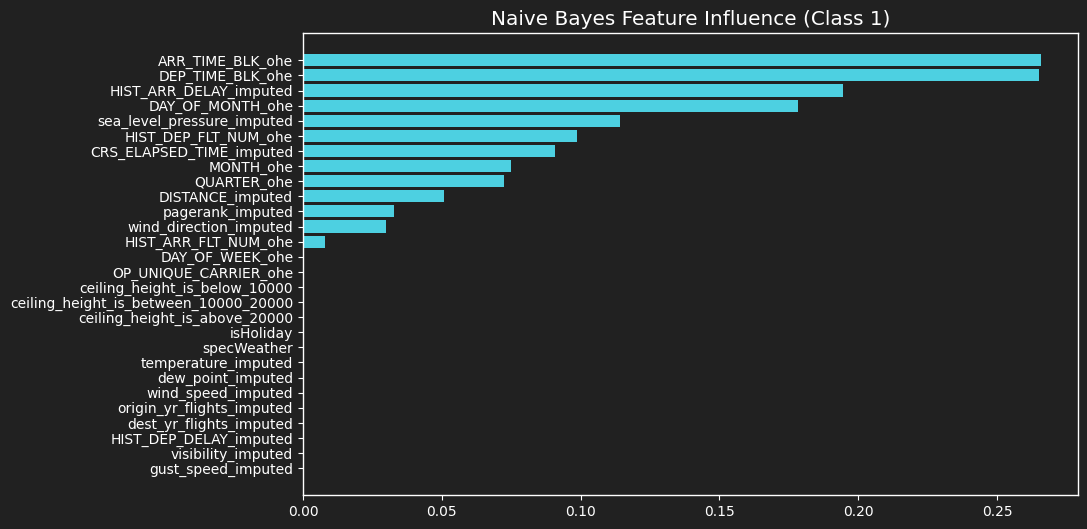

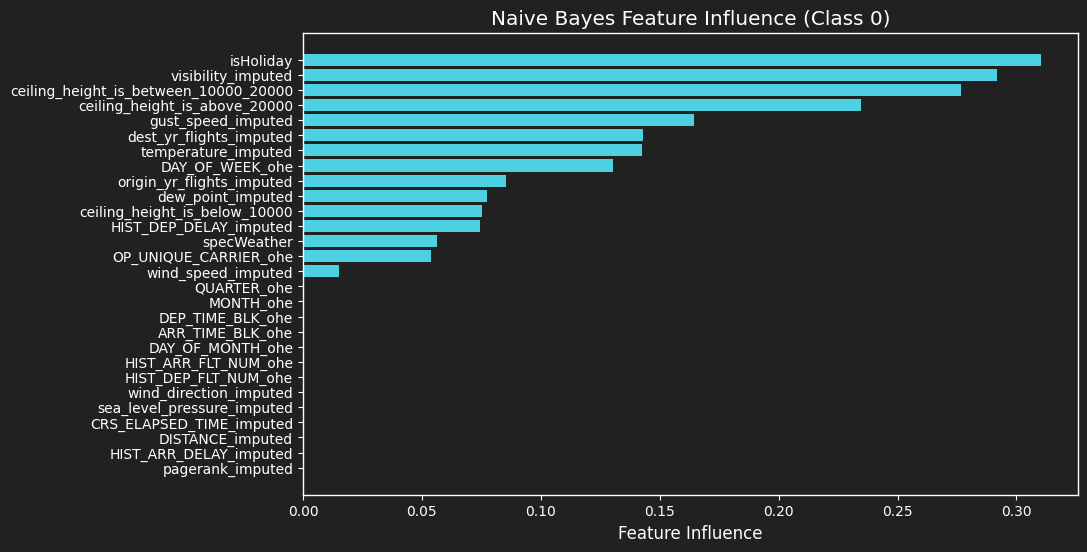

In [0]:
# Define styling for both plots
bar_color = "#4DD0E1"
background_color = "#212121"
label_color = "white"

# Plot Feature Influence for Class 1
plt.figure(figsize=(10, 6))
plt.barh(sorted_names_1, sorted_values_1, color=bar_color)
plt.xlabel("", color=label_color)
plt.ylabel("", color=label_color)
plt.title("Naive Bayes Feature Influence (Class 1)", color=label_color)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(background_color)
plt.gcf().set_facecolor(background_color)
plt.tick_params(colors=label_color)
plt.grid(False)
plt.show()

# Plot Feature Influence for Class 0
plt.figure(figsize=(10, 6))
plt.barh(sorted_names_0, sorted_values_0, color=bar_color)
plt.xlabel("Feature Influence", color=label_color)
plt.ylabel("", color=label_color)
plt.title("Naive Bayes Feature Influence (Class 0)", color=label_color)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(background_color)
plt.gcf().set_facecolor(background_color)
plt.tick_params(colors=label_color)
plt.grid(False)
plt.show()


# Load Optuna Study and evaluate

In [0]:
# Define the paths
local_pickle_path = f"/tmp/{study_name}.pkl"
remote_pickle_path = f"{team_blob_url}/data/{study_name}.pkl"

# Download the pickle file from Azure Blob Storage to the local filesystem
dbutils.fs.cp(remote_pickle_path, f"file://{local_pickle_path}")

print(f"Study downloaded locally to {local_pickle_path}")

# Load the Optuna study object from the local pickle file
with open(local_pickle_path, "rb") as f:
    study = pickle.load(f)

print("Study successfully loaded from the pickle file")



Study downloaded locally to /tmp/nb_study_1yr_2024_12_08.pkl
Study successfully loaded from the pickle file


In [0]:
study.trials

[FrozenTrial(number=0, state=1, values=[0.5152546632465778], datetime_start=datetime.datetime(2024, 12, 10, 4, 37, 39, 368469), datetime_complete=datetime.datetime(2024, 12, 10, 4, 47, 2, 541017), params={'smoothing': 0.013425962629732262, 'imputation_strategy': 'mean'}, user_attrs={'train_weighted_average_auc': 0.5000608671377217, 'train_weighted_average_precision': 0.5158987011329615, 'train_weighted_average_recall': 0.5233506848980652, 'train_weighted_average_accuracy': 0.5162672880337101, 'train_weighted_average_f1_micro': 0.5162672880337101, 'train_weighted_average_f1_macro': 0.5196246930155134, 'train_weighted_average_f1_weighted': 0.5195490915264347, 'train_weighted_average_fbeta': 0.517341486767736, 'val_weighted_average_auc': 0.5041905880313416, 'val_weighted_average_precision': 0.5137523803256546, 'val_weighted_average_recall': 0.5219902977630148, 'val_weighted_average_accuracy': 0.5147044761564223, 'val_weighted_average_f1_micro': 0.5147044761564223, 'val_weighted_average_f1

# Optuna Visualizations

/root/.ipykernel/148521/command-59813923271795-3843448733:1: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_timeline(study)


<Axes: title={'center': 'Timeline Plot'}, xlabel='Datetime', ylabel='Trial'>

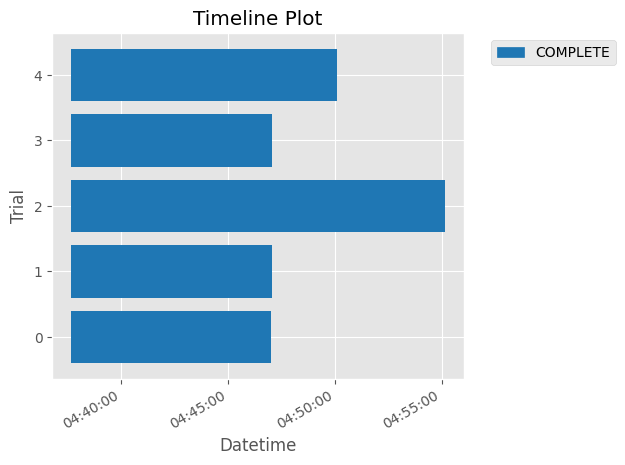

In [0]:
optuna.visualization.matplotlib.plot_timeline(study)

In [0]:
optuna.visualization.plot_param_importances(study)

2024/12/10 05:17:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5f68038201145a2aea35165a42ffe79', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/12/10 05:17:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-moth-653 at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508/runs/d5f68038201145a2aea35165a42ffe79.
2024/12/10 05:17:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508.


---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
File <command-57921511669517>, line 1
----> 1 optuna.visualization.plot_param_importances(study)

File /databricks/python/lib/python3.12/site-packages/optuna/visualization/_param_importances.py:191, in plot_param_importances(study, evaluator, params, target, target_name)
    121 """Plot hyperparameter importances.
    122 
    123 Example:
   (...)
    187     A :class:`plotly.graph_objects.Figure` object.
    188 """
    190 _imports.check()
--> 191 importances_infos = _get_importances_infos(study, evaluator, params, target, target_name)
    192 return _get_importances_plot(importances_infos, study)

File /databricks/python/lib/python3.12/site-packages/optuna/visualization/_param_importances.py:82, in _get_importances_infos(study, evaluator, params, target, target_name)
     79 if target or not study._is_multi_objective():
     80     

In [0]:
optuna.visualization.plot_parallel_coordinate(study)

/root/.ipykernel/148521/command-59813923271802-1455980257:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

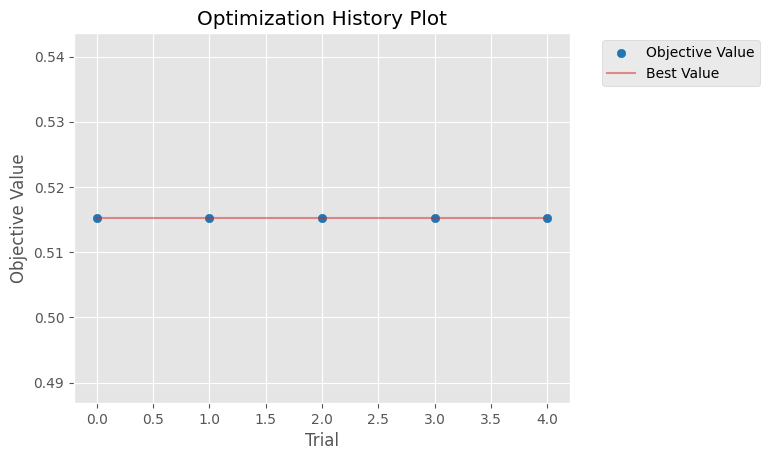

In [0]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [0]:
# optuna.visualization.matplotlib.plot_param_importances(study)

In [0]:
optuna.visualization.matplotlib.plot_contour(study)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
optuna.visualization.matplotlib.plot_intermediate_values(study)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:431)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:507)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:611)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:631)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:271)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
optuna.visualization.matplotlib.plot_terminator_improvement(study)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:431)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:507)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:611)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:631)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:271)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

# Test set

In [0]:
def calculate_metrics(prediction, beta=0.5):
    tp = prediction.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    fp = prediction.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = prediction.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
    tn = prediction.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F-beta score with beta=0.5
    beta = 0.5
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    return fbeta, precision, recall

def blind_test(train, test, study):
    
    # Hyperparameter search
    best_params = study.best_params
    imputation_strategy = best_params["imputation_strategy"]

    imputer = Imputer(
        strategy=imputation_strategy,
        inputCols=numerical_cols, 
        outputCols=[f"{column}_imputed" for column in numerical_cols]
        )

    final_assembler = VectorAssembler(
        inputCols=[f"{column}_ohe" for column in need_ohe_cols] + already_ohe_cols + [f"{column}_imputed" for column in numerical_cols],
        outputCol="features"  
    )

    # Handle categorical columns
    indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index", handleInvalid="keep") for column in need_ohe_cols]
    encoders = [OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe") for column in need_ohe_cols]

    # Create model
    smoothing = best_params["smoothing"]
    model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

    # Create pipeline stages
    pipeline =  Pipeline(stages=indexers + encoders + [imputer] + [final_assembler, model])

    pipeline_model = pipeline.fit(train)
    training_preds = pipeline_model.transform(train)
    test_preds = pipeline_model.transform(test)

    predictions = {"train": training_preds, "test": test_preds}

    # Store metrics per key
    train_test = []
    # Calculate training and validation metrics
    for key, prediction in predictions.items():
        fbeta, precision, recall = calculate_metrics(prediction)

        # Store metrics for this fold
        p_key = "precision_" + key
        r_key = "recall_" + key
        fb_key = "fbeta_" + key

        train_test.append({
            p_key: precision,
            r_key: recall,
            fb_key: fbeta
        })
    
    metrics = train_test[0] | train_test[1]

    return metrics

In [0]:
test_5yr = spark.read.parquet(f'{team_blob_url}/data/5yr_test.parquet')

In [0]:
test_5yr_shifted = shift_to_positive(df, numerical_cols, manual=True, manual_value=149)

'Abs min value < 0, shifting wind_direction by 149'

'Abs min value < 0, shifting temperature by 149'

'Abs min value < 0, shifting sea_level_pressure by 149'

'Abs min value < 0, shifting CRS_ELAPSED_TIME by 149'

'Abs min value < 0, shifting DISTANCE by 149'

'Abs min value < 0, shifting dew_point by 149'

'Abs min value < 0, shifting wind_speed by 149'

'Abs min value < 0, shifting origin_yr_flights by 149'

'Abs min value < 0, shifting dest_yr_flights by 149'

'Abs min value < 0, shifting HIST_ARR_DELAY by 149'

'Abs min value < 0, shifting HIST_DEP_DELAY by 149'

'Abs min value < 0, shifting visibility by 149'

'Abs min value < 0, shifting gust_speed by 149'

'Abs min value < 0, shifting pagerank by 149'

In [0]:
check_min_values(test_5yr, numerical_cols)

column min median max wind_direction 1.0 190.0 360.0 temperature -38.9 17.2 999.9 sea_level_pressure 960.0 1016.1 1059.3 CRS_ELAPSED_TIME 1.0 123.0 948.0 DISTANCE 45.0 631.0 2724.0 dew_point -41.5 10.0 999.9 wind_speed 0.0 3.1 999.9 origin_yr_flights 6.25 100221.0 373483.0 dest_yr_flights 6.25 100221.0 373483.0 HIST_ARR_DELAY -94.0 -7.0 2695.0 HIST_DEP_DELAY -82.0 -2.0 2710.0 visibility 0.0 16.093 999.999 gust_speed 1.0 5.0 9.0 pagerank 0.17883507962688425 4.483331069304802 15.637630705266732

In [0]:
check_min_values(test_5yr_shifted, numerical_cols)

column min median max wind_direction 457.0 643.0 813.0 temperature 417.0 471.3 1452.9 sea_level_pressure 1429.4 1469.3 1512.6 CRS_ELAPSED_TIME 354.0 578.0 1053.0 DISTANCE 478.0 1120.0 3177.0 dew_point 414.5 464.7 1452.9 wind_speed 453.0 456.6 1452.9 origin_yr_flights 470.5 116712.75 373936.0 dest_yr_flights 459.25 116712.75 373936.0 HIST_ARR_DELAY 288.0 448.0 2397.0 HIST_DEP_DELAY 249.0 452.0 3208.0 visibility 453.0 469.093 1452.999 gust_speed 454.0 458.0 462.0 pagerank 453.1787660540032 457.4405003082913 471.8706526487627

In [0]:
blind_test_metrics = blind_test(train = shifted_df, test = test_5yr_shifted, study=study)

2024/12/10 05:33:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b70aa654f6c745449d615494a14278fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/12/10 05:34:40 WARNING mlflow.pyspark.ml: Model outputs contain unsupported Spark data types: [StructField('QUARTER_ohe', VectorUDT(), True), StructField('MONTH_ohe', VectorUDT(), True), StructField('DAY_OF_WEEK_ohe', VectorUDT(), True), StructField('OP_UNIQUE_CARRIER_ohe', VectorUDT(), True), StructField('DEP_TIME_BLK_ohe', VectorUDT(), True), StructField('ARR_TIME_BLK_ohe', VectorUDT(), True), StructField('DAY_OF_MONTH_ohe', VectorUDT(), True), StructField('HIST_ARR_FLT_NUM_ohe', VectorUDT(), True), StructField('HIST_DEP_FLT_NUM_ohe', VectorUDT(), True), StructField('features', VectorUDT(), True), StructField('rawPrediction', VectorUDT(), True), StructField('probability', VectorUDT(), True)]. Output schema is not be log

2024/12/10 05:37:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/59813923271508/b70aa654f6c745449d615494a14278fb/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.2']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2024/12/10 05:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-cow-308 at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508/runs/b70aa654f6c745449d615494a14278fb.
2024/12/10 05:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-4248444930383559.19.azuredatabricks.net/ml/experiments/59813923271508.


In [0]:
print(blind_test_metrics)

{'precision_train': 0.5141672361647877, 'recall_train': 0.523932687773347, 'fbeta_train': 0.5160910949853191, 'precision_test': 0.5141106628079183, 'recall_test': 0.5240653985467462, 'fbeta_test': 0.5160712398003577}


# Graveyard

In [0]:
# from pyspark.sql.functions import col

# # ======================================== Set for Testing =============================================
# # Update as needed
# test=False

# # ===================================== Set data and n trials ==========================================

# # Set df and n_trials
# if test:
#     df = test_df
#     n_trials = 1
# else:
#     df = shifted_df
#     n_trials = 5

# # ============================= Define Objective Function + Metrics ===================================
# def objective(trial):

#     # Hyperparameter search
#     smoothing = trial.suggest_float("smoothing", 0.01, 10.0, log=True)
#     imputation_strategy = trial.suggest_categorical("imputation_strategy", ["mean", "median"])

#     # Apply inputer for all numerical columns
#     imputer = Imputer(
#         strategy=imputation_strategy,
#         inputCols=numerical_cols,
#         outputCols=[f"{col}_imputed" for col in numerical_cols]
#     )

#     indexers = [
#         StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
#         for col in categorical_cols
#     ]
#     encoders = [
#         OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
#         for col in categorical_cols
#     ]

#     assembler = VectorAssembler(
#         inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
#         outputCol="features"
#         )

#     model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

#     pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model]) 

#     evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")

#     fold_metrics = []
#     num_folds = df.select('foldCol').distinct().count()
#     fold_weights = range(1, num_folds + 1)

#     for fold in range(num_folds):
#         train_data, val_data = get_train_val_data(df, fold)

#         pipeline_model = pipeline.fit(train_data)

#         # Evaluate on train data
#         train_predictions = pipeline_model.transform(train_data)
#         train_auc = evaluator.evaluate(train_predictions)

#         # Evaluate on validation data
#         val_predictions = pipeline_model.transform(val_data)
#         val_auc = evaluator.evaluate(val_predictions)

#         # Compute metrics for train and validation
#         for split_name, data, auc in [
#             ("train", train_predictions, train_auc),
#             ("val", val_predictions, val_auc)
#         ]:
#             tp = data.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
#             fp = data.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
#             fn = data.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
#             tn = data.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#             accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

#             f1_micro = accuracy
#             f1_macro = (precision + recall) / 2 if (precision + recall) > 0 else 0
#             f1_weighted = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#             beta = 0.5
#             fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

#             fold_metrics.append({
#                 "fold": fold,
#                 "split": split_name,
#                 "auc": auc,
#                 "precision": precision,
#                 "recall": recall,
#                 "accuracy": accuracy,
#                 "f1_micro": f1_micro,
#                 "f1_macro": f1_macro,
#                 "f1_weighted": f1_weighted,
#                 "fbeta": fbeta,
#                 "weight": fold_weights[fold]
#             })

#     # Aggregate metrics across folds for train and val separately
#     metrics_per_split = {}

#     for split_name in ["train", "val"]:
#         # Calculate total weight for the specific split
#         total_weight = sum(m["weight"] for m in fold_metrics if m["split"] == split_name)

#         # Aggregate metrics for the specific split
#         metrics_per_split[split_name] = {
#             metric: sum(m[metric] * m["weight"] for m in fold_metrics if m["split"] == split_name) / total_weight
#             for metric in ["auc", "precision", "recall", "accuracy", "f1_micro", "f1_macro", "f1_weighted", "fbeta"]
#         }

#     # Log metrics for train and validation
#     for split_name, metrics in metrics_per_split.items():
#         for metric_name, metric_value in metrics.items():
#             trial.set_user_attr(f"{split_name}_weighted_average_{metric_name}", metric_value)

#     trial.report(metrics_per_split["val"]["fbeta"], step=0)
    
#     if trial.should_prune():
#         raise optuna.exceptions.TrialPruned()
    
#     print('val fbeta:', metrics_per_split["val"]["fbeta"])
#     return metrics_per_split["val"]["fbeta"]

# # ======================================== Run Optuna Study ============================================

# # Create Optuna study with MedianPruner
# study = optuna.create_study(direction="maximize", 
#                             pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1
#                                                 )
#                             )
# study.optimize(objective, 
#                n_trials=n_trials, 
#                n_jobs=-1
#                )


In [0]:
# # Clean the data
# filtered_df = balanced_df.drop(*ignore_cols)
# filtered_df = filtered_df.dropDuplicates()

# # Remove outliers
# outlier_bounds = {}
# for col_name in numerical_cols:
#     # Compute Q1, Q3, and IQR for the column
#     quantiles = filtered_df.approxQuantile(col_name, [0.25, 0.75], 0.0)  # Approx quantiles: Q1 and Q3

#     outlier_bounds[col_name] = quantiles

#     if len(quantiles) == 2:

#         q1, q3 = quantiles
#         iqr = q3 - q1
#         lower_bound = q1 - 1.5 * iqr
#         upper_bound = q3 + 1.5 * iqr
        
#         # Filter rows within the IQR bounds
#         filtered_df = filtered_df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

# Checkpoint
# filtered_df.write.parquet(f'{team_blob_url}/data/1yr_preprocessed_no.parquet')

In [0]:

# display(f'{team_blob_url}/data/1yr_folds.parquet')

# # Load data from parquet file
# folds_df = spark.read.parquet(f"{team_blob_url}/data/1yr_folds.parquet")
# # test_df = spark.read.parquet(f"{team_blob_url}/data/5yr_test.parquet")

# # Drop nulls
# folds_df = folds_df.filter(folds_df.DEP_DEL15.isNotNull())

# # Get class counts and dct to prepare for undersampling
# pre_balance_class_counts = folds_df.groupBy("DEP_DEL15").count().collect()
# pre_balance_class_dct = {row["DEP_DEL15"]: row["count"] for row in pre_balance_class_counts}

# # Get df by class
# minority_class_df = folds_df.filter(col("DEP_DEL15") == 1)  
# majority_class_df = folds_df.filter(col("DEP_DEL15") == 0)

# # Get fraction
# fraction = pre_balance_class_dct[1] / pre_balance_class_dct[0]  # Fraction for sampling majority class
# undersampled_majority_df = majority_class_df.sample(withReplacement=False, fraction=fraction, seed=42)
# balanced_df = minority_class_df.union(undersampled_majority_df)

# # Get groupby to visualize update
# post_balance_class_counts = balanced_df.groupBy("DEP_DEL15").count().collect()

# # Show results
# display('Pre-balanced:', pre_balance_class_counts)
# display('Post-balanced:', post_balance_class_counts)

# # groupy by on fold and split
# display(balanced_df.groupBy("foldCol", "split").count().orderBy("foldCol", "split"))

# Define normalization and feature assembler dynamically
    # scaler = MinMaxScaler(inputCol="features_for_impute", outputCol="scaled_features_minmax")
    # assembler = VectorAssembler(
    #     inputCols=["scaled_features_minmax"] + [f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols,
    #     outputCol="features",
    # )
# def objective(trial):

#     # If naive bayes is true, drop scaling as it risks introducing negative values due to float errors
#     naive_bayes = True

#     try:
#         # Hyperparameter search
#         smoothing = trial.suggest_float("smoothing", 0.01, 10.0, log=True)
#         imputation_strategy = trial.suggest_categorical("imputation_strategy", ["mean", "median"])
        
#         if naive_bayes == False:
#             normalize_method = trial.suggest_categorical("normalize_method", ["minmax"])

#         # Apply inputer for all numerical columns
#         imputer = Imputer(
#             strategy=imputation_strategy,
#             inputCols=numerical_cols,
#             outputCols=[f"{col}_imputed" for col in numerical_cols]
#         )
        
#         if naive_bayes == False:
#             # Applying scaling to imputed columns that are not at risk of being qualified as "constants"
#             scaled_cols = [f"{col}_imputed" for col in non_constant_numerical_cols]
#             assembler_for_scaling = VectorAssembler(inputCols=scaled_cols, outputCol="features_for_scaling")
#             scaler = MinMaxScaler(inputCol="features_for_scaling", outputCol="scaled_features_minmax")
            
#             # Final feature assembler that outputs features
#             assembler = VectorAssembler(
#             inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + scaled_cols, 
#             outputCol="features"
#             )
#         else:
#             # Final feature assembler that outputs features
#             assembler = VectorAssembler(
#                 inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols, 
#                 outputCol="features"
#             )

#         # Create index to be used for the ohe columns (e.g., Q1, Q2 and Q3 have indices of 0.0, 1.0, 2.0, respectively.
#         indexers = [
#             StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
#             for col in categorical_cols
#             ]
        
#         # The index labels are used to map the index labels to the ohe vector inde
#         encoders = [
#             OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
#             for col in categorical_cols
#         ]
        
#         # Create Naive Bayes classifier
#         model = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

#         # Create pipeline stages
#         if naive_bayes:
#             pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model]) 
#         else:
#             pipeline = Pipeline(stages=[imputer + assembler_for_scaling + scaler] + indexers + encoders + [assembler, model]) 
        

#         # Initialize evaluator
#         evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")

#         # Initialize metrics storage
#         fold_metrics = []

#         # Define number of folds
#         num_folds = shifted_df.select('foldCol').distinct().count()

#         # Define fold weights
#         fold_weights = range(1, num_folds + 1)

#         # Loop through folds
#         for fold in range(num_folds):

#             # Get train and validation data
#             train_data, val_data = get_train_val_data(shifted_df, fold)

#             # Train the pipeline
#             pipeline_model = pipeline.fit(train_data)

#             # Transform validation data
#             predictions = pipeline_model.transform(val_data)

#             # Compute AUC
#             auc = evaluator.evaluate(predictions)

#             # Custom metrics calculation
#             tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
#             fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
#             fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
#             tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

#             # Calculate metrics
#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#             accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

#             # F1-score calculations
#             f1_micro = accuracy
#             f1_macro = (precision + recall) / 2 if (precision + recall) > 0 else 0
#             f1_weighted = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#             # F-beta score with beta=0.5
#             beta = 0.5
#             fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

#             # Store metrics for this fold
#             fold_metrics.append({
#                 "fold": fold,
#                 "auc": auc,
#                 "precision": precision,
#                 "recall": recall,
#                 "accuracy": accuracy,
#                 "f1_micro": f1_micro,
#                 "f1_macro": f1_macro,
#                 "f1_weighted": f1_weighted,
#                 "fbeta": fbeta,
#                 "weight": fold_weights[fold - 1]  # Add weight to the fold metrics
#             })

#         # Aggregate metrics across folds with weights
#         total_weight = sum([m["weight"] for m in fold_metrics])
#         avg_metrics = {
#             metric: sum([m[metric] * m["weight"] for m in fold_metrics]) / total_weight
#             for metric in ["auc", "precision", "recall", "accuracy", "f1_micro", "f1_macro", "f1_weighted", "fbeta"]
#         }

#         # Log metrics to Optuna trial
#         for metric_name, metric_value in avg_metrics.items():
#             trial.set_user_attr(f"weighted_average_{metric_name}", metric_value)

#         # Report primary metric for pruning
#         trial.report(avg_metrics["fbeta"], step=0)

#         # Prune trial if not promising
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#         return avg_metrics["fbeta"]

#     except Exception as e:
#         trial.set_user_attr("failure_reason", str(e))
#         raise optuna.exceptions.TrialPruned()


# # Create Optuna study with MedianPruner
# study = optuna.create_study(direction="maximize", 
#                             pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1
#                                                 )
#                             )
# study.optimize(objective, 
#                n_trials=10, 
#                n_jobs=-1
#                )
    # pipeline = Pipeline(stages=[imputer, assembler_for_impute, scaler] + indexers + encoders + [final_assembler, nb])

In [0]:



# THIS CODE WORKS, BUT NO CONTROL OVER SPLIT

# # Global imputer
# imputer = Imputer(strategy="mean", inputCols=numerical_cols, outputCols=[f"{col}_imputed" for col in numerical_cols])

# # Global assembler for scaling (applies before scaling or log transformation)
# assembler_for_scaling = VectorAssembler(inputCols=[f"{col}_imputed" for col in numerical_cols], outputCol="features_for_scaling")

# def objective(trial):
#     # Hyperparameter search
#     smoothing = trial.suggest_float("smoothing", 0.01, 10.0, log=True)
#     imputation_strategy = trial.suggest_categorical("imputation_strategy", ["mean", "median"])
#     normalize_method = trial.suggest_categorical("normalize_method", ["minmax"])

#     # Define dynamic imputer
#     imputer = Imputer(strategy=imputation_strategy, inputCols=numerical_cols, outputCols=[f"{col}_imputed" for col in numerical_cols])

#     # Define assembler for scaling
#     assembler_for_scaling = VectorAssembler(inputCols=[f"{col}_imputed" for col in numerical_cols], outputCol="features_for_scaling")

#     # Define normalization and feature assembler dynamically
#     if normalize_method == "minmax":
#         scaler = MinMaxScaler(inputCol="features_for_scaling", outputCol="scaled_features_minmax")
#         assembler = VectorAssembler(
#             inputCols=["scaled_features_minmax"] + [f"{col}_ohe" for col in categorical_cols] + ohe_cols,
#             outputCol="features",
#         )
#     else:  # Log normalization
#         scaler = VectorAssembler(
#             inputCols=[f"{col}_log" for col in numerical_cols], outputCol="scaled_features_log"
#         )
#         assembler = VectorAssembler(
#             inputCols=["scaled_features_log"] + [f"{col}_ohe" for col in categorical_cols] + ohe_cols,
#             outputCol="features",
#         )

#     # Handle categorical columns
#     indexers = [
#     StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
#     for col in categorical_cols
#     ]
    
#     encoders = [
#         OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
#         for col in categorical_cols
#     ]
    
#     # Create Naive Bayes classifier
#     nb = NaiveBayes(featuresCol="features", labelCol=label_col, smoothing=smoothing)

#     # Create pipeline stages
#     pipeline = Pipeline(stages=[imputer, assembler_for_scaling, scaler] + indexers + encoders + [assembler, nb])

#     # Set evaluator
#     evaluator = BinaryClassificationEvaluator(labelCol=label_col)

#     param_grid = ParamGridBuilder() \
#         .addGrid(nb.smoothing, [1.0]) \
#         .build()

#     # Cross-validation with foldCol
#     crossval = CrossValidator(
#         estimator=pipeline,
#         estimatorParamMaps=param_grid,
#         evaluator=evaluator,
#         numFolds=5,
#         foldCol="foldCol",
#         parallelism=1
#     )

#     # Train model
#     cv_model = crossval.fit(df_folds)

#     # Generate predictions
#     predictions = cv_model.transform(df_folds)

#     # Initialize metrics dictionary
#     metrics = {}

#     # Binary classification metrics
#     metrics["auc_roc"] = evaluator.evaluate(predictions)

#     # Custom F-beta calculation
#     tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
#     fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
#     fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
#     tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

#     # Calculate metrics
#     metrics["accuracy"] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
#     metrics["precision"] = tp / (tp + fp) if (tp + fp) > 0 else 0
#     metrics["recall"] = tp / (tp + fn) if (tp + fn) > 0 else 0

#     # F1-score calculations
#     metrics["f1_micro"] = metrics["accuracy"]  # Equivalent for micro-averaging in binary classification
#     metrics["f1_macro"] = (metrics["precision"] + metrics["recall"]) / 2 if (metrics["precision"] + metrics["recall"]) > 0 else 0
#     metrics["f1_weighted"] = (2 * metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"]) if (metrics["precision"] + metrics["recall"]) > 0 else 0

#     # F-beta score with beta=0.5
#     beta = 0.5
#     if metrics["precision"] + metrics["recall"] == 0:
#         metrics["fbeta"] = 0
#     else:
#         metrics["fbeta"] = (1 + beta**2) * (metrics["precision"] * metrics["recall"]) / ((beta**2 * metrics["precision"]) + metrics["recall"])

#     # Log metrics to Optuna trial
#     for metric_name, metric_value in metrics.items():
#         trial.set_user_attr(metric_name, metric_value)

#     # Report primary metric for pruning
#     trial.report(metrics["fbeta"], step=0)

#     # Prune trial if not promising
#     if trial.should_prune():
#         raise optuna.exceptions.TrialPruned()

#     return metrics["fbeta"]